In [17]:
!pip install tensorflow==2.12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 75.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 65.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 43.9 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.4
    Uninst

In [18]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-04-07 03:55:58--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.203.208, 52.216.171.181, 16.182.70.160, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.203.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.2’

jena_climate_2009_2 100%[===================>]  12.94M  60.8MB/s    in 0.2s    

2024-04-07 03:55:58 (60.8 MB/s) - ‘jena_climate_2009_2016.csv.zip.2’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
replace jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

**Analyzing the Jena weather dataset unveils 420,451 entries containing information on 15 distinct attributes.**

In [1]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

num_variables = len(header)
print("Number of variables:", num_variables)
num_rows = len(lines)
print("Number of rows:", num_rows)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
Number of variables: 15
Number of rows: 420451


**The process of parsing the data involves converting the values separated by commas into floating-point numbers. Specific values are then stored for later processing or analysis in the raw_data and temperature arrays.**

In [2]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

Text(0, 0.5, 'Temperature')

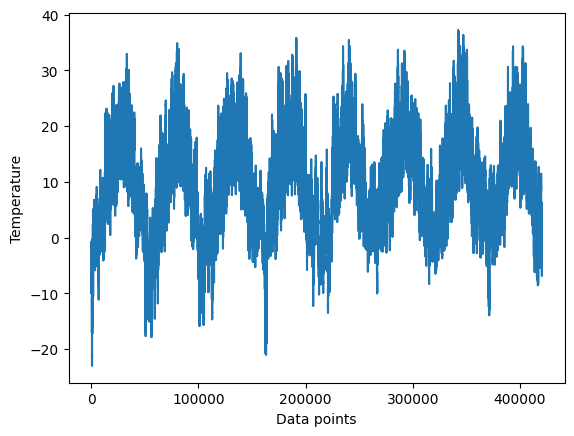

In [3]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.xlabel('Data points')
plt.ylabel('Temperature')

**To visualize the temperature time series for the initial ten days, we'll plot the data points. Considering there are 144 data points per day, this amounts to 1440 data points over the span of ten days.**

Text(0, 0.5, 'Temperature')

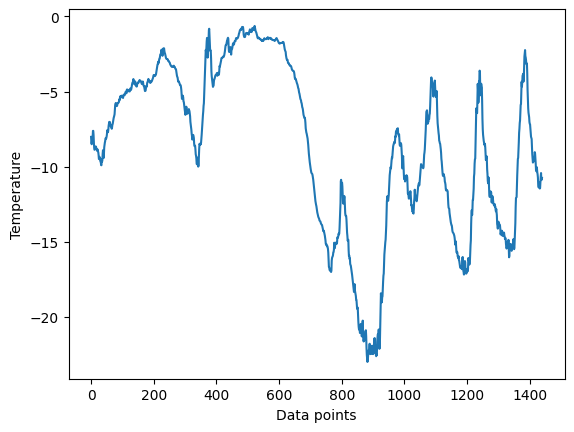

In [4]:
plt.plot(range(1440), temperature[:1440])
plt.xlabel('Data points')
plt.ylabel('Temperature')

**Determining the sample distribution for data splitting involves allocating 50% for training and 25% for validation.**

In [5]:
nums_train_samples = int(0.5 * len(raw_data))
nums_val_samples = int(0.25 * len(raw_data))
nums_test_samples = len(raw_data) - nums_train_samples - nums_val_samples
print("num_train_samples:", nums_train_samples)
print("num_val_samples:", nums_val_samples)
print("num_test_samples:", nums_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


**Preparing the data**

**Normalizing the data- Vectorization is unnecessary since the data is already numerical. However, considering the varied scales across variables—for instance, temperature ranging from -20 to +30 and pressure measured in millibars,it's recommended to standardize all variables.**

In [6]:
mean = raw_data[:nums_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:nums_train_samples].std(axis=0)
raw_data /= std

In [7]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Generating datasets for testing, validation, and training is crucial due to the significant redundancy in the dataset's samples. Allocating memory for each sample explicitly would be inefficient; instead, we'll generate samples dynamically as needed.**

In [8]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=nums_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=nums_train_samples,
    end_index=nums_train_samples + nums_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=nums_train_samples + nums_val_samples)

**Inspecting the output of one of our datasets**

In [9]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


**A common-sense, non-machine-learning baseline**

**Calculating the baseline Mean Absolute Error (MAE) involves utilizing the "evaluate_naive_method" function, which serves as an initial step to gauge the efficacy of a basic forecasting approach. This approach predicts the subsequent value in a sequence by relying solely on the last value of the input sequence.**

In [10]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


A reasonable baseline strategy would entail predicting that the temperature in the next 24 hours will remain the same as the current temperature. The validation MAE (Mean Absolute Error) when employing this simple baseline is 2.44 degrees Celsius, whereas the test MAE stands at 2.62 degrees Celsius. In simpler terms, assuming the future temperature remains constant with the present temperature leads to an average deviation of approximately 2.5 degrees

**A basic machine-learning model - Dense Layer**

**Training and evaluating a densely connected model**

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [12]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)]

In [13]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

In [14]:
history = model.fit(train_dataset, epochs=10,
                    validation_data = val_dataset, callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 46s 55ms/step - loss: 12.2398 - mae: 2.7095 - val_loss: 13.4869 - val_mae: 2.9093
Epoch 2/10
819/819 [==============================] - 51s 62ms/step - loss: 8.9854 - mae: 2.3596 - val_loss: 10.2393 - val_mae: 2.5285
Epoch 3/10
819/819 [==============================] - 44s 54ms/step - loss: 8.2849 - mae: 2.2638 - val_loss: 11.6120 - val_mae: 2.6929
Epoch 4/10
819/819 [==============================] - 44s 53ms/step - loss: 7.8581 - mae: 2.2045 - val_loss: 10.6884 - val_mae: 2.5897
Epoch 5/10
819/819 [==============================] - 45s 55ms/step - loss: 7.5488 - mae: 2.1617 - val_loss: 10.4534 - val_mae: 2.5591
Epoch 6/10
819/819 [==============================] - 50s 60ms/step - loss: 7.3167 - mae: 2.1276 - val_loss: 10.2956 - val_mae: 2.5394
Epoch 7/10
819/819 [==============================] - 43s 52ms/step - loss: 7.1388 - mae: 2.1012 - val_loss: 11.4022 - val_mae: 2.6606
Epoch 8/10
819/819 [==============================] - 

In [15]:
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 15s 37ms/step - loss: 11.2405 - mae: 2.6448
Test MAE: 2.64


**Plotting results**

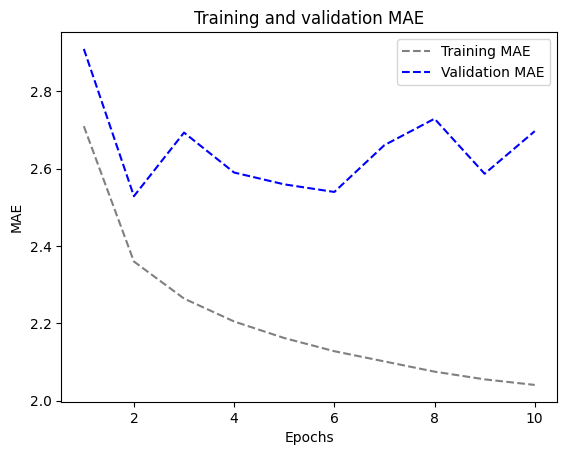

In [16]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**Let's try a 1D convolutional model**

In [17]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 87s 105ms/step - loss: 22.5161 - mae: 3.7273 - val_loss: 18.9887 - val_mae: 3.4186
Epoch 2/10
819/819 [==============================] - 85s 103ms/step - loss: 16.0627 - mae: 3.1838 - val_loss: 16.9518 - val_mae: 3.2688
Epoch 3/10
819/819 [==============================] - 87s 106ms/step - loss: 14.6488 - mae: 3.0353 - val_loss: 16.4393 - val_mae: 3.2399
Epoch 4/10
819/819 [==============================] - 81s 99ms/step - loss: 13.7206 - mae: 2.9307 - val_loss: 14.8815 - val_mae: 3.0335
Epoch 5/10
819/819 [==============================] - 84s 103ms/step - loss: 12.9974 - mae: 2.8529 - val_loss: 16.6920 - val_mae: 3.2566
Epoch 6/10
819/819 [==============================] - 88s 107ms/step - loss: 12.3756 - mae: 2.7777 - val_loss: 19.0718 - val_mae: 3.4368
Epoch 7/10
819/819 [==============================] - 87s 106ms/step - loss: 11.9366 - mae: 2.7268 - val_loss: 15.4787 - val_mae: 3.0930
Epoch 8/10
819/819 [======================

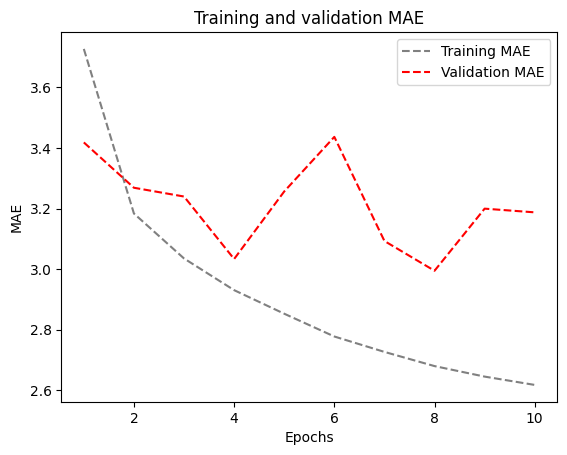

In [18]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="red",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

The convolutional model's underperformance compared to the common sense or dense model might be attributed to two factors:

The assumption of translation invariance isn't well-suited for weather data.


The temporal order of the data is essential. Recent past data holds more predictive value for forecasting the next day's temperature compared to older data. However, a 1D convolutional neural network struggles to adequately capture this crucial temporal sequence.







**A Simple RNN**

**1.An RNN layer that can process sequences of any length**

In [19]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimRNN.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SimRNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 68s 81ms/step - loss: 139.0453 - mae: 9.7000 - val_loss: 143.9115 - val_mae: 9.8935
Epoch 2/10
819/819 [==============================] - 67s 81ms/step - loss: 136.3480 - mae: 9.5600 - val_loss: 143.8137 - val_mae: 9.8850
Epoch 3/10
819/819 [==============================] - 66s 80ms/step - loss: 136.2635 - mae: 9.5522 - val_loss: 143.6793 - val_mae: 9.8748
Epoch 4/10
819/819 [==============================] - 65s 79ms/step - loss: 136.1895 - mae: 9.5460 - val_loss: 143.7726 - val_mae: 9.8828
Epoch 5/10
819/819 [==============================] - 71s 87ms/step - loss: 136.1800 - mae: 9.5451 - val_loss: 143.6366 - val_mae: 9.8673
Epoch 6/10
819/819 [==============================] - 68s 83ms/step - loss: 136.1674 - mae: 9.5426 - val_loss: 143.5285 - val_mae: 9.8507
Epoch 7/10
819/819 [==============================] - 68s 82ms/step - loss: 136.1768 - mae: 9.5409 - val_loss: 143.5514 - val_mae: 9.8547
Epoch 8/10
819/819 [==============

**2.Simple RNN - Stacking RNN layers**

In [20]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SRNN2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 147s 176ms/step - loss: 136.9916 - mae: 9.5760 - val_loss: 143.4455 - val_mae: 9.8397
Epoch 2/10
819/819 [==============================] - 144s 176ms/step - loss: 136.0120 - mae: 9.5192 - val_loss: 143.4456 - val_mae: 9.8418
Epoch 3/10
819/819 [==============================] - 129s 157ms/step - loss: 135.9342 - mae: 9.5101 - val_loss: 143.4765 - val_mae: 9.8461
Epoch 4/10
819/819 [==============================] - 145s 177ms/step - loss: 135.9061 - mae: 9.5065 - val_loss: 143.4239 - val_mae: 9.8374
Epoch 5/10
819/819 [==============================] - 130s 158ms/step - loss: 135.8850 - mae: 9.5034 - val_loss: 143.4485 - val_mae: 9.8387
Epoch 6/10
819/819 [==============================] - 145s 177ms/step - loss: 135.8638 - mae: 9.5002 - val_loss: 143.3944 - val_mae: 9.8327
Epoch 7/10
819/819 [==============================] - 145s 177ms/step - loss: 135.8452 - mae: 9.4978 - val_loss: 143.4111 - val_mae: 9.8360
Epoch 8/10
819/819 [

**A Simple GRU (Gated Recurrent Unit)**

In [21]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_gru.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 129s 154ms/step - loss: 41.8356 - mae: 4.6631 - val_loss: 12.6361 - val_mae: 2.6695
Epoch 2/10
819/819 [==============================] - 126s 154ms/step - loss: 10.4519 - mae: 2.5167 - val_loss: 9.5110 - val_mae: 2.3785
Epoch 3/10
819/819 [==============================] - 128s 156ms/step - loss: 9.4324 - mae: 2.4001 - val_loss: 9.5556 - val_mae: 2.3811
Epoch 4/10
819/819 [==============================] - 108s 131ms/step - loss: 9.0932 - mae: 2.3579 - val_loss: 9.4714 - val_mae: 2.3780
Epoch 5/10
819/819 [==============================] - 108s 131ms/step - loss: 8.8872 - mae: 2.3314 - val_loss: 9.3656 - val_mae: 2.3733
Epoch 6/10
819/819 [==============================] - 125s 152ms/step - loss: 8.7225 - mae: 2.3086 - val_loss: 9.4933 - val_mae: 2.3807
Epoch 7/10
819/819 [==============================] - 106s 129ms/step - loss: 8.5715 - mae: 2.2892 - val_loss: 10.2256 - val_mae: 2.4479
Epoch 8/10
819/819 [========================

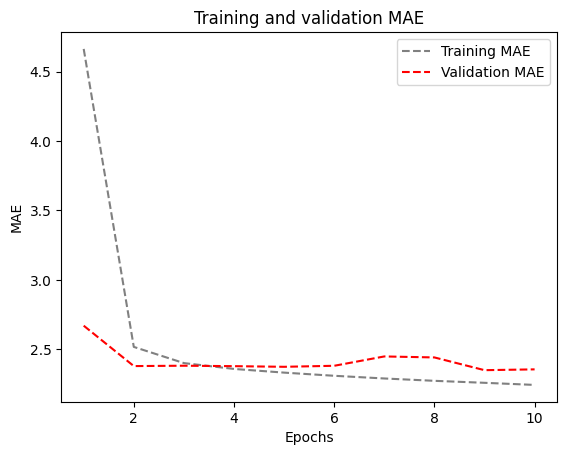

In [22]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="red",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**LSTM(Long Short-Term Memory )**

**1.LSTM-Simple**

In [23]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 124s 149ms/step - loss: 42.2930 - mae: 4.7510 - val_loss: 12.8063 - val_mae: 2.7121
Epoch 2/10
819/819 [==============================] - 106s 130ms/step - loss: 10.9987 - mae: 2.5849 - val_loss: 9.6839 - val_mae: 2.4100
Epoch 3/10
819/819 [==============================] - 127s 155ms/step - loss: 9.7901 - mae: 2.4463 - val_loss: 9.5182 - val_mae: 2.3884
Epoch 4/10
819/819 [==============================] - 100s 121ms/step - loss: 9.3951 - mae: 2.3923 - val_loss: 9.5103 - val_mae: 2.3899
Epoch 5/10
819/819 [==============================] - 101s 123ms/step - loss: 9.0962 - mae: 2.3516 - val_loss: 9.5763 - val_mae: 2.3987
Epoch 6/10
819/819 [==============================] - 121s 148ms/step - loss: 8.8520 - mae: 2.3178 - val_loss: 9.6864 - val_mae: 2.4150
Epoch 7/10
819/819 [==============================] - 100s 122ms/step - loss: 8.6630 - mae: 2.2904 - val_loss: 9.7453 - val_mae: 2.4224
Epoch 8/10
819/819 [=========================

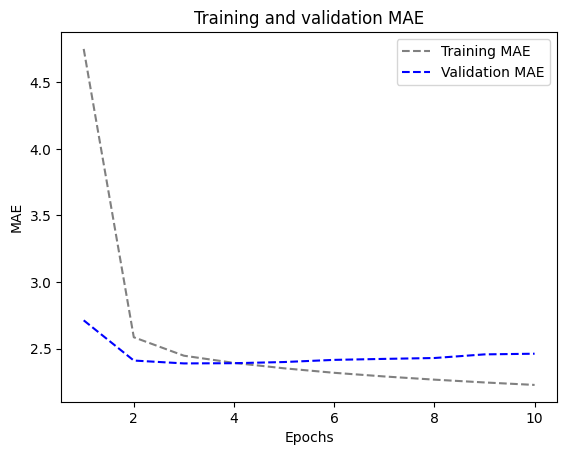

In [24]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**2.LSTM - dropout Regularization**

In [25]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 182s 218ms/step - loss: 43.7813 - mae: 4.9210 - val_loss: 12.8152 - val_mae: 2.7187
Epoch 2/10
819/819 [==============================] - 178s 217ms/step - loss: 19.9421 - mae: 3.4304 - val_loss: 9.9105 - val_mae: 2.4483
Epoch 3/10
819/819 [==============================] - 157s 192ms/step - loss: 18.1050 - mae: 3.2729 - val_loss: 9.6219 - val_mae: 2.4210
Epoch 4/10
819/819 [==============================] - 177s 216ms/step - loss: 17.3138 - mae: 3.1953 - val_loss: 9.7537 - val_mae: 2.4439
Epoch 5/10
819/819 [==============================] - 158s 192ms/step - loss: 16.6672 - mae: 3.1405 - val_loss: 9.6125 - val_mae: 2.4247
Epoch 6/10
819/819 [==============================] - 161s 196ms/step - loss: 16.2180 - mae: 3.0997 - val_loss: 9.7351 - val_mae: 2.4474
Epoch 7/10
819/819 [==============================] - 177s 216ms/step - loss: 15.7988 - mae: 3.0632 - val_loss: 9.6973 - val_mae: 2.4360
Epoch 8/10
819/819 [====================

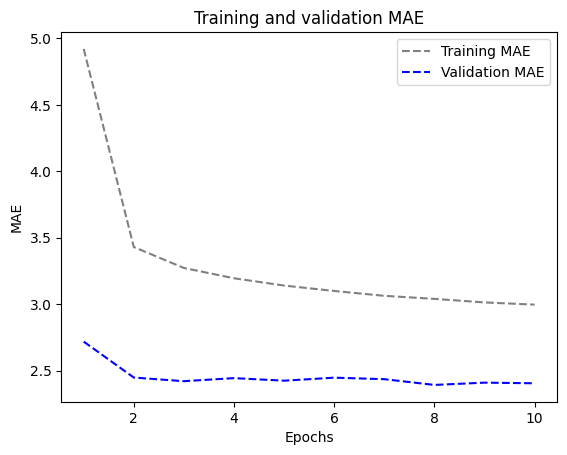

In [26]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**Using a stacked configuration of LSTM with 16 units.**

In [27]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, return_sequences=True)(inputs)
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked1.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked1.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 183s 220ms/step - loss: 35.1847 - mae: 4.2951 - val_loss: 11.8044 - val_mae: 2.6213
Epoch 2/10
819/819 [==============================] - 168s 204ms/step - loss: 10.1211 - mae: 2.4710 - val_loss: 9.3981 - val_mae: 2.3688
Epoch 3/10
819/819 [==============================] - 175s 214ms/step - loss: 8.7693 - mae: 2.3079 - val_loss: 9.9519 - val_mae: 2.4703
Epoch 4/10
819/819 [==============================] - 174s 212ms/step - loss: 8.0994 - mae: 2.2185 - val_loss: 11.0689 - val_mae: 2.5702
Epoch 5/10
819/819 [==============================] - 164s 199ms/step - loss: 7.6575 - mae: 2.1571 - val_loss: 9.9865 - val_mae: 2.4654
Epoch 6/10
819/819 [==============================] - 164s 200ms/step - loss: 7.3101 - mae: 2.1087 - val_loss: 10.4799 - val_mae: 2.5288
Epoch 7/10
819/819 [==============================] - 180s 220ms/step - loss: 6.9561 - mae: 2.0586 - val_loss: 10.3510 - val_mae: 2.5281
Epoch 8/10
819/819 [======================

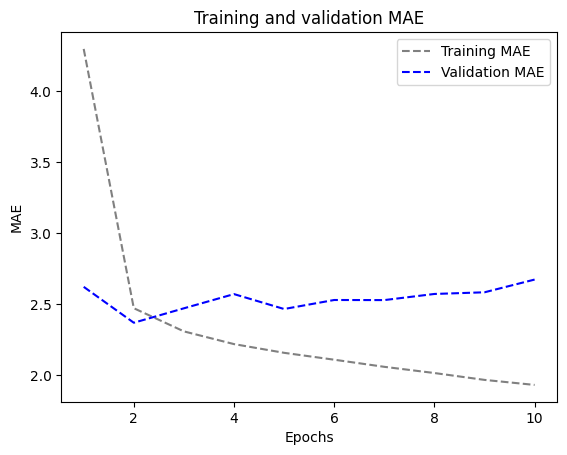

In [28]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**LSTM configured in a stacked architecture with 32 units.**

In [29]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, return_sequences=True)(inputs)
x = layers.LSTM(32)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 278s 335ms/step - loss: 23.8270 - mae: 3.4625 - val_loss: 10.7278 - val_mae: 2.5633
Epoch 2/10
819/819 [==============================] - 277s 338ms/step - loss: 8.0692 - mae: 2.2155 - val_loss: 10.2431 - val_mae: 2.4841
Epoch 3/10
819/819 [==============================] - 287s 350ms/step - loss: 6.5329 - mae: 1.9845 - val_loss: 11.4516 - val_mae: 2.6662
Epoch 4/10
819/819 [==============================] - 283s 346ms/step - loss: 5.6481 - mae: 1.8343 - val_loss: 11.5454 - val_mae: 2.6495
Epoch 5/10
819/819 [==============================] - 275s 336ms/step - loss: 4.9757 - mae: 1.7172 - val_loss: 12.0309 - val_mae: 2.7077
Epoch 6/10
819/819 [==============================] - 292s 356ms/step - loss: 4.4470 - mae: 1.6137 - val_loss: 12.0812 - val_mae: 2.7126
Epoch 7/10
819/819 [==============================] - 251s 306ms/step - loss: 4.0471 - mae: 1.5336 - val_loss: 12.4397 - val_mae: 2.7572
Epoch 8/10
819/819 [====================

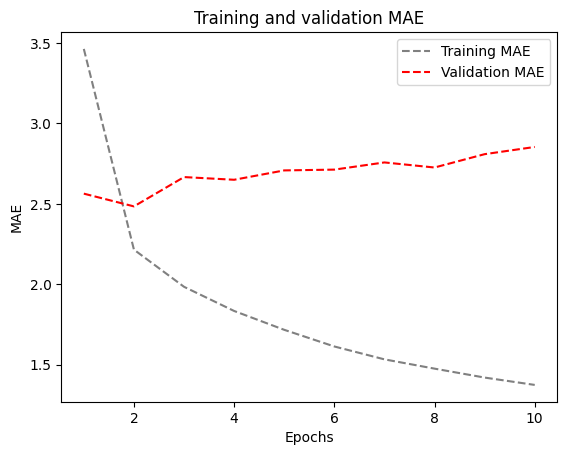

In [30]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="red",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**LSTM - Stacked setup with 8 units**

In [31]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, return_sequences=True)(inputs)
x = layers.LSTM(8)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked3.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked3.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 163s 195ms/step - loss: 79.2139 - mae: 6.8927 - val_loss: 42.6346 - val_mae: 4.9278
Epoch 2/10
819/819 [==============================] - 155s 189ms/step - loss: 24.9706 - mae: 3.6797 - val_loss: 14.4771 - val_mae: 2.8419
Epoch 3/10
819/819 [==============================] - 163s 199ms/step - loss: 11.8272 - mae: 2.6469 - val_loss: 10.0345 - val_mae: 2.4540
Epoch 4/10
819/819 [==============================] - 154s 187ms/step - loss: 10.0951 - mae: 2.4699 - val_loss: 9.6498 - val_mae: 2.4124
Epoch 5/10
819/819 [==============================] - 149s 182ms/step - loss: 9.7065 - mae: 2.4224 - val_loss: 9.8138 - val_mae: 2.4410
Epoch 6/10
819/819 [==============================] - 153s 187ms/step - loss: 9.5045 - mae: 2.3968 - val_loss: 9.6830 - val_mae: 2.4309
Epoch 7/10
819/819 [==============================] - 167s 203ms/step - loss: 9.3249 - mae: 2.3743 - val_loss: 9.6451 - val_mae: 2.4207
Epoch 8/10
819/819 [=====================

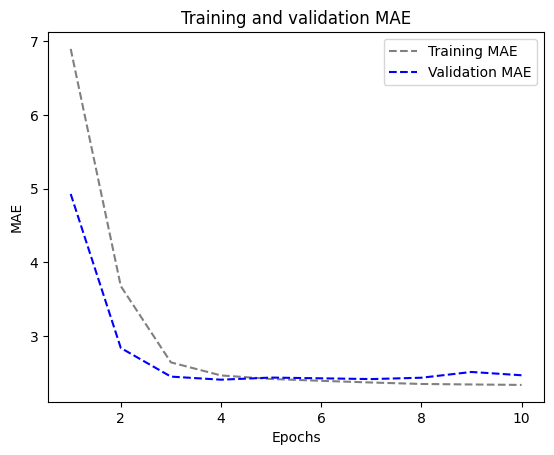

In [32]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**Utilizing LSTM with dropout regularization in a stacked configuration.**

In [33]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(8, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_LSTM_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 281s 336ms/step - loss: 76.3634 - mae: 6.7480 - val_loss: 37.2357 - val_mae: 4.5727
Epoch 2/10
819/819 [==============================] - 281s 342ms/step - loss: 32.9320 - mae: 4.2955 - val_loss: 14.2403 - val_mae: 2.8203
Epoch 3/10
819/819 [==============================] - 280s 341ms/step - loss: 24.6154 - mae: 3.7557 - val_loss: 11.2669 - val_mae: 2.5738
Epoch 4/10
819/819 [==============================] - 278s 338ms/step - loss: 22.6034 - mae: 3.6011 - val_loss: 10.0736 - val_mae: 2.4459
Epoch 5/10
819/819 [==============================] - 273s 334ms/step - loss: 21.1949 - mae: 3.4936 - val_loss: 10.1812 - val_mae: 2.4716
Epoch 6/10
819/819 [==============================] - 264s 322ms/step - loss: 20.3154 - mae: 3.4199 - val_loss: 9.9378 - val_mae: 2.4462
Epoch 7/10
819/819 [==============================] - 276s 336ms/step - loss: 19.1920 - mae: 3.3339 - val_loss: 9.3116 - val_mae: 2.3711
Epoch 8/10
819/819 [================

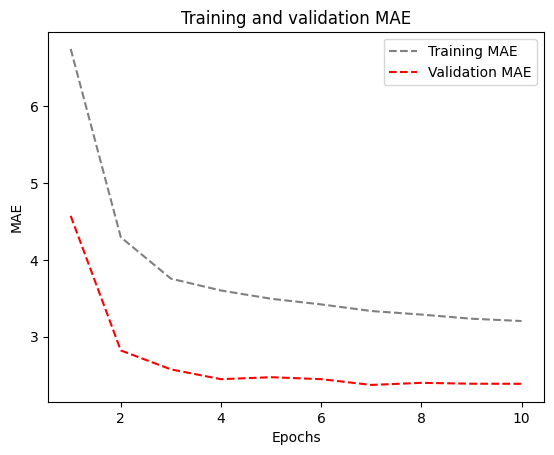

In [34]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="red",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**Bidirectional LSTM**

In [35]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirec_LSTM.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                     callbacks=callbacks)

model = keras.models.load_model("jena_bidirec_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 170s 202ms/step - loss: 28.5440 - mae: 3.8140 - val_loss: 11.0089 - val_mae: 2.5729
Epoch 2/10
819/819 [==============================] - 156s 190ms/step - loss: 9.5196 - mae: 2.4070 - val_loss: 9.5414 - val_mae: 2.3992
Epoch 3/10
819/819 [==============================] - 154s 188ms/step - loss: 8.6519 - mae: 2.2856 - val_loss: 9.6447 - val_mae: 2.4135
Epoch 4/10
819/819 [==============================] - 164s 200ms/step - loss: 8.1460 - mae: 2.2166 - val_loss: 10.1056 - val_mae: 2.4682
Epoch 5/10
819/819 [==============================] - 164s 201ms/step - loss: 7.7843 - mae: 2.1655 - val_loss: 10.1114 - val_mae: 2.4684
Epoch 6/10
819/819 [==============================] - 166s 202ms/step - loss: 7.4825 - mae: 2.1256 - val_loss: 9.5086 - val_mae: 2.4122
Epoch 7/10
819/819 [==============================] - 166s 202ms/step - loss: 7.2912 - mae: 2.0976 - val_loss: 10.5250 - val_mae: 2.5049
Epoch 8/10
819/819 [=======================

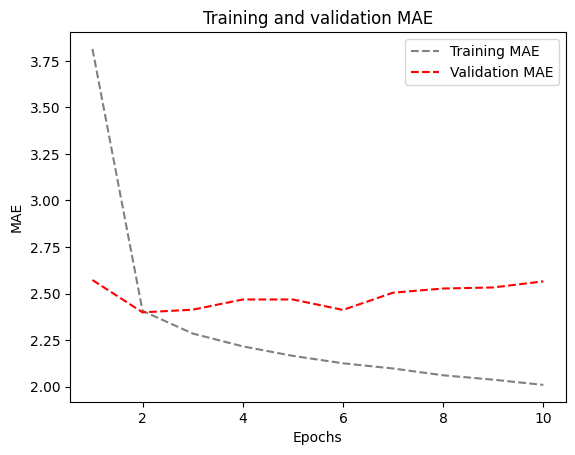

In [36]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="red",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

1D Convnets and LSTM together

In [37]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(64, 3, activation='relu')(inputs)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(128, 3, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Reshape((-1, 128))(x)  # Reshape the data to be 3D
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Conv_LSTM.keras", save_best_only=True)
]

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_Conv_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 137s 164ms/step - loss: 45.9333 - mae: 5.0566 - val_loss: 25.9375 - val_mae: 3.9380
Epoch 2/10
819/819 [==============================] - 136s 166ms/step - loss: 17.1254 - mae: 3.1947 - val_loss: 24.1392 - val_mae: 3.8395
Epoch 3/10
819/819 [==============================] - 114s 139ms/step - loss: 14.2394 - mae: 2.9222 - val_loss: 23.1079 - val_mae: 3.8075
Epoch 4/10
819/819 [==============================] - 114s 138ms/step - loss: 12.7537 - mae: 2.7658 - val_loss: 23.2273 - val_mae: 3.8702
Epoch 5/10
819/819 [==============================] - 136s 166ms/step - loss: 11.6519 - mae: 2.6371 - val_loss: 24.7538 - val_mae: 4.0361
Epoch 6/10
819/819 [==============================] - 116s 141ms/step - loss: 10.8294 - mae: 2.5370 - val_loss: 22.7684 - val_mae: 3.8064
Epoch 7/10
819/819 [==============================] - 133s 163ms/step - loss: 10.1622 - mae: 2.4531 - val_loss: 22.4981 - val_mae: 3.7838
Epoch 8/10
819/819 [==============

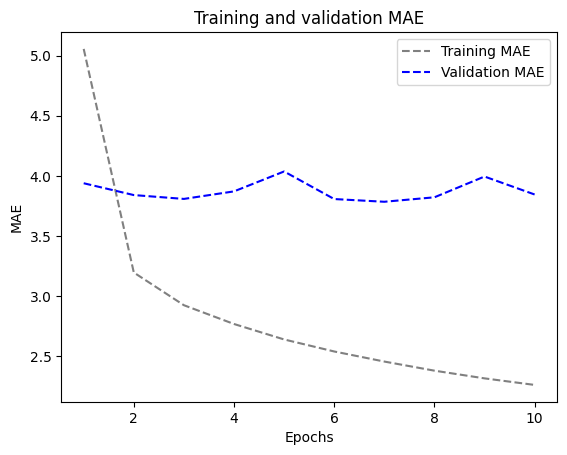

In [38]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

We built 14 models: Following are the details;

**Model 1**: common-sense, non-machine-learning baseline

**Model 2**: A basic machine-learning model

**Model 3**: 1D convolutional model

**Model 4**: Simple RNN layer that can process sequences of any length

**Model 5**: Simple RNN - Stacking RNN layers

**Model 6**: A Simple GRU (Gated Recurrent Unit)

**Model 7**: LSTM-Simple

**Model 8**: LSTM - dropout Regularization

**Model 9**: Stacked setup with 16 units

**Model 10**: Stacked setup with 32 units

**Model 11**: Stacked setup with 8 units

**Model 12**: LSTM - dropout-regularized, stacked

**Model 13**: Bidirectional LSTM

**Model 14**: 1D Convnets and LSTM togther

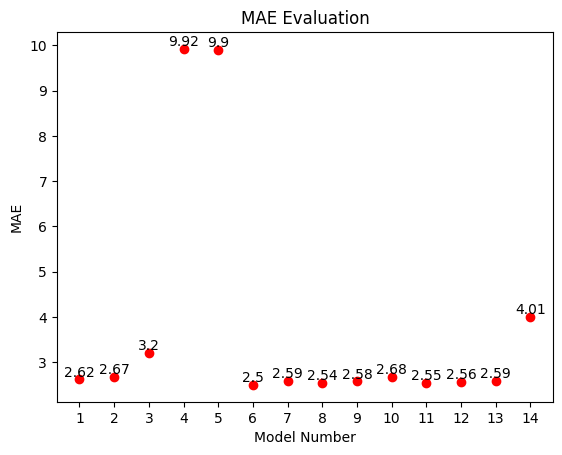

In [39]:
Models = ("1","2","3","4","5","6","7","8","9","10","11","12","13","14")
Mae = (2.62,2.67,3.2,9.92,9.9,2.5,2.59,2.54,2.58,2.68,2.55,2.56,2.59,4.01)

# MAE Evaluation
plt.scatter(Models, Mae, color="red")
plt.title("MAE Evaluation")
plt.xlabel("Model Number")
plt.ylabel("MAE")

for (xi, yi) in zip(Models,Mae):
    plt.text(xi, yi, yi, va='bottom', ha='center')

plt.show()
